In [1]:
import numpy as np
import pandas as pd

from data_loader import load_names_from_web

from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, ccf

In [2]:
# load data
dfraw = load_names_from_web(category="both", hide_pre_1937=True)
dfraw.sample(5)

state  year       name M/F  count
7369970    NY  1992        Lia   F     14
5330769    CA  1994    Derrell   M      8
6095801    LA  1977      Edith   F      9
777159     US  1958  Bernadene   F      8
2554544    FL  2006       Alen   M      5

In [3]:
# add percentage column to normalize by population
state_year = dfraw.groupby(['state', 'year']).sum(numeric_only=True).reset_index()
df2 = pd.merge(dfraw, state_year, on=['state', 'year'], how='left', suffixes=('', '_agg'))
df2['perc'] = 100*df2['count']/df2['count_agg']
df2.drop(['count_agg'], axis=1, inplace=True)
df2.sample(5)

state  year      name M/F  count      perc
3562332    TX  1969      Lora   F     59  0.028128
3547384    TX  1958  Felicita   F      5  0.002129
1845960    DC  2009     Miles   M     18  0.248413
3402277    OR  1976   Allyson   F      7  0.023337
2444113    IA  1952    Marion   M     14  0.023600

In [4]:
# df2.to_csv('temp2024mar11.csv', index=False)
# df2 = pd.read_csv('temp2024mar11.csv')
# df2.head()

In [5]:
# Are there any really high percentages?
df2[df2['perc']>6]

state  year  name M/F  count      perc
4174146    AK  1937  Mary   F     41  7.044674

In [6]:
# number of time series available (some might have length 1)
len(df2[['name', 'M/F', 'state']].groupby(['name', 'M/F', 'state']))

431064

## a function for comparison
We're interested in pairwise distances. For example, 
* Which states have similar names?
* which names have similar time series?

The following function uses https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html to make comparisons.

In [7]:
def melted_distance_matrix(df, var_name='state', metrics=['euclidean']):
    '''
    This function makes pairwise comparisons, using one or more metrics.
    The rows of the df will be compared to each other.
    The resulting df will have columns like: row_a, row_b, euclidean_distance, cosine_distance
    
    The function assumes a single-level row index, where each row index is descriptive.
    'var_name' is the desired label for the row index. So, if comparing states, set var_name='state'
    '''

    if isinstance(df.index, pd.MultiIndex):
        ids = df.index.map('_'.join)  # Join MultiIndex levels with an underscore
    else:
        ids = df.index    
    
    ids = df.index
    
    first = True
    name1 = var_name + '1'
    name2 = var_name + '2'
    for metric in metrics:    
        distances = pdist(df, metric=metric)
        distance_matrix = squareform(distances)
        distance_df = pd.DataFrame(distance_matrix, index=ids, columns=ids)
        
        if isinstance(df.index, pd.MultiIndex):
            distance_df.columns = distance_df.columns.to_flat_index() # added by Paul
            distance_df.index.name = var_name  # Set a name for the index before resetting it
        distance_df.reset_index(inplace=True)  # Reset index to make it a column for melting
             
        distance_df = distance_df.melt(id_vars=[var_name], var_name=name2, value_name=metric)
        distance_df.rename(columns={var_name: name1}, inplace=True)
        distance_df = distance_df[distance_df[name1] != distance_df[name2]]

        # delete duplicates (AL AK is the same as AK AL)
        distance_df = distance_df[distance_df[name1] < distance_df[name2]]   
        
        if first:
            melted = distance_df
            first = False
        else:
            melted = pd.merge(melted, distance_df, on=[name1, name2])
    
    return melted    

## What states are *currently* most similar to each other?
Think of each state as a vector. The percentage for each name is a component of the vector.

In [8]:
max_year = df2['year'].max()
dflatest = df2[df2['year']==max_year]
dflatest = dflatest[['state', 'name', 'M/F', 'perc']]
latest_pivot = dflatest.pivot_table(index=['state'], columns=['name', 'M/F'], values='perc', fill_value=0)
latest_pivot.head()

name  Aaban Aabha Aabir Aadam Aadan Aadarsh Aadav Aaden Aadhav Aadhavan  ...  \
M/F       M     F     M     M     M       M     M     M      M        M  ...   
state                                                                    ...   
AK      0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0    0.0      0.0  ...   
AL      0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0    0.0      0.0  ...   
AR      0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0    0.0      0.0  ...   
AZ      0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0    0.0      0.0  ...   
CA      0.0   0.0   0.0   0.0   0.0     0.0   0.0   0.0    0.0      0.0  ...   

name  Zyrah Zyre Zyree Zyren Zyriah Zyrie Zyrin Zyron Zyrus Zyva  
M/F       F    M     M     M      F     M     M     M     M    F  
state                                                             
AK      0.0  0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  0.0  
AL      0.0  0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  0.0  
AR      0.0  0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  0.0  
AZ      0.0  0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  0.0  
CA      0.0  0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  0.0  

[5 rows x 31915 columns]

In [9]:
state_comparison = melted_distance_matrix(latest_pivot, 'state', ['euclidean', 'cosine'])
state_comparison.head()

state1 state2  euclidean    cosine
0     AK     AL   3.661921  0.184658
1     AK     AR   3.371064  0.154257
2     AL     AR   1.421160  0.059248
3     AK     AZ   3.711656  0.193954
4     AL     AZ   2.401130  0.186564

In [10]:
# least similar states (euclidean)
state_comparison.sort_values(by=['euclidean'], ascending=False).head(10)

state1 state2  euclidean    cosine
1113     NM     VT   5.946715  0.404293
1085     CA     VT   5.931284  0.399274
1286     HI     WY   5.904495  0.376697
1279     CA     WY   5.879437  0.368322
1124     TX     VT   5.873667  0.377757
1092     HI     VT   5.828362  0.376244
1282     DC     WY   5.801758  0.356732
1318     TX     WY   5.788612  0.336904
1306     NJ     WY   5.784321  0.359821
1307     NM     WY   5.762556  0.362488

All of the top 10 include Wyoming or Vermont. They are the least populous states (even less than DC).

In [11]:
# least similar states (cosine)
state_comparison.sort_values(by=['cosine'], ascending=False).head(10)

state1 state2  euclidean    cosine
1113     NM     VT   5.946715  0.404293
1085     CA     VT   5.931284  0.399274
1124     TX     VT   5.873667  0.377757
1286     HI     WY   5.904495  0.376697
1092     HI     VT   5.828362  0.376244
1279     CA     WY   5.879437  0.368322
1307     NM     WY   5.762556  0.362488
1306     NJ     WY   5.784321  0.359821
1112     NJ     VT   5.690835  0.359112
1232     DC     WV   4.598366  0.358100

In [12]:
# most similar states (euclidean)
state_comparison.sort_values(by=['euclidean']).head(10)

state1 state2  euclidean    cosine
617      MI     OH   0.733385  0.019191
361      GA     NC   0.761915  0.021803
610      IN     OH   0.784861  0.021484
907      CA     TX   0.807098  0.022697
619      MO     OH   0.824811  0.021518
1062     NC     VA   0.843345  0.023287
291      IN     MO   0.855813  0.023746
888      NC     TN   0.869490  0.026795
592      NJ     NY   0.880790  0.019860
973      NC     US   0.900620  0.021660

Funny that Michigan and ohio state are such rivals!

In [13]:
# most similar states (cosine)
state_comparison.sort_values(by=['cosine']).head(10)

state1 state2  euclidean    cosine
960      IL     US   0.929809  0.017539
617      MI     OH   0.733385  0.019191
592      NJ     NY   0.880790  0.019860
1079     US     VA   1.065593  0.020536
610      IN     OH   0.784861  0.021484
619      MO     OH   0.824811  0.021518
973      NC     US   0.900620  0.021660
361      GA     NC   0.761915  0.021803
907      CA     TX   0.807098  0.022697
1062     NC     VA   0.843345  0.023287

In [14]:
# states closest to US in general
state_comparison[(state_comparison['state1']=='US') | (state_comparison['state2']=='US')].sort_values(by=['euclidean']).head(10)

state1 state2  euclidean    cosine
973      NC     US   0.900620  0.021660
960      IL     US   0.929809  0.017539
956      GA     US   0.965861  0.036284
989      TX     US   1.065290  0.045697
1079     US     VA   1.065593  0.020536
1172     US     WA   1.079046  0.025403
955      FL     US   1.083273  0.031748
984      PA     US   1.109306  0.030353
968      MI     US   1.212732  0.043470
966      MD     US   1.216425  0.034528

In [15]:
# states furthest from US in general
state_comparison[(state_comparison['state1']=='US') | (state_comparison['state2']=='US')].sort_values(by=['euclidean'], ascending=False).head(12)

state1 state2  euclidean    cosine
1319     US     WY   5.512701  0.239484
1125     US     VT   5.421313  0.241500
946      AK     US   3.737255  0.133869
953      DC     US   3.560054  0.153302
967      ME     US   3.495858  0.152650
976      NH     US   3.493049  0.131813
957      HI     US   3.462523  0.180862
974      ND     US   3.366588  0.168846
972      MT     US   3.359994  0.166162
985      RI     US   3.354824  0.096300
987      SD     US   3.225737  0.157504
954      DE     US   3.163042  0.091141

This is basically a list of the least populous states!

(Function below to use only "common" names) 

In [16]:
def most_common_names_by_perc(df_with_perc, n, state='all'):
    '''
    returns the df but filtered for n common names, with n/2 Male and n/2 Female names.
    if the input df contains state data: 
        a) it might "reward" states that lack name diversity
        b) it will include regionally popular names
        
    df_with_perc: a dataframe that at least contains the columns name, M/F and perc.
    state: default is 'all' but can do 'US' or any state code
    '''
    num_per_gender = int(np.ceil(n/2))
    
    if state!='all':
        df_with_perc = df_with_perc.loc[df_with_perc['state']==state]
    
    # clean this up: 1 was working out "view versus a copy" warnings
    zzz0 = df_with_perc.copy()
    zzz0.sort_values(by='perc', ascending=False, inplace=True)
    
    zzz1 = zzz0.copy()
    zzz2 = zzz0.copy()
    
    top_m_names = list(zzz1.loc[zzz1['M/F'] == 'M']['name'].unique()[:num_per_gender])
    top_f_names = list(zzz2.loc[zzz2['M/F'] == 'F']['name'].unique()[:num_per_gender])
    
    dfm = df_with_perc.loc[(df_with_perc['name'].isin(top_m_names)) & (df_with_perc['M/F'] == 'M')]
    dff = df_with_perc.loc[(df_with_perc['name'].isin(top_f_names)) & (df_with_perc['M/F'] == 'F')]
    
    most_common_df = pd.concat([dff, dfm], ignore_index=True)
    
    return most_common_df

## What *names* are currently most similar to each other, in terms of distibution across states?

In [17]:
# there are speed issues with so many names. So get a subset
dflatest2 = dflatest.copy()
print(dflatest2.shape)
dflatest2 = most_common_names_by_perc(dflatest2, 4000)
print(dflatest2.shape)

(127379, 4)
(85521, 4)


In [18]:
latest_pivot = dflatest2.pivot_table(index=['name', 'M/F'], columns=['state'], values='perc', fill_value=0)
latest_pivot.head()

state              AK       AL        AR        AZ        CA        CO  \
name    M/F                                                              
Aadhya  F    0.000000  0.00000  0.021926  0.000000  0.009166  0.000000   
Aadya   F    0.000000  0.00000  0.000000  0.000000  0.004722  0.000000   
Aaliyah F    0.168188  0.10978  0.092089  0.152781  0.168045  0.095647   
Aamir   M    0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
Aanya   F    0.000000  0.00000  0.000000  0.000000  0.009722  0.000000   

state              CT       DC   DE        FL  ...        TN        TX  \
name    M/F                                    ...                       
Aadhya  F    0.000000  0.00000  0.0  0.006652  ...  0.007471  0.010303   
Aadya   F    0.000000  0.00000  0.0  0.003326  ...  0.000000  0.003238   
Aaliyah F    0.139784  0.14498  0.0  0.144131  ...  0.095632  0.123934   
Aamir   M    0.000000  0.00000  0.0  0.007207  ...  0.000000  0.003533   
Aanya   F    0.000000  0.00000  0.0  0.003880  ...  0.007471  0.007948   

state              US        UT        VA   VT        WA        WI        WV  \
name    M/F                                                                    
Aadhya  F    0.007972  0.000000  0.012392  0.0  0.019439  0.000000  0.000000   
Aadya   F    0.003004  0.000000  0.000000  0.0  0.014579  0.000000  0.000000   
Aaliyah F    0.097267  0.054609  0.095009  0.0  0.108535  0.088861  0.125839   
Aamir   M    0.003569  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
Aanya   F    0.005622  0.000000  0.008262  0.0  0.014579  0.000000  0.000000   

state         WY  
name    M/F       
Aadhya  F    0.0  
Aadya   F    0.0  
Aaliyah F    0.0  
Aamir   M    0.0  
Aanya   F    0.0  

[5 rows x 52 columns]

In [19]:
# I was having trouble making the function work for a multiindex, so here is some manual pre-preocessing:

# flatten the row index
latest_pivot.index = latest_pivot.index.map('_'.join)
# rename the row index
latest_pivot.index.name = 'name'

latest_pivot.head()

state            AK       AL        AR        AZ        CA        CO  \
name                                                                   
Aadhya_F   0.000000  0.00000  0.021926  0.000000  0.009166  0.000000   
Aadya_F    0.000000  0.00000  0.000000  0.000000  0.004722  0.000000   
Aaliyah_F  0.168188  0.10978  0.092089  0.152781  0.168045  0.095647   
Aamir_M    0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
Aanya_F    0.000000  0.00000  0.000000  0.000000  0.009722  0.000000   

state            CT       DC   DE        FL  ...        TN        TX  \
name                                         ...                       
Aadhya_F   0.000000  0.00000  0.0  0.006652  ...  0.007471  0.010303   
Aadya_F    0.000000  0.00000  0.0  0.003326  ...  0.000000  0.003238   
Aaliyah_F  0.139784  0.14498  0.0  0.144131  ...  0.095632  0.123934   
Aamir_M    0.000000  0.00000  0.0  0.007207  ...  0.000000  0.003533   
Aanya_F    0.000000  0.00000  0.0  0.003880  ...  0.007471  0.007948   

state            US        UT        VA   VT        WA        WI        WV  \
name                                                                         
Aadhya_F   0.007972  0.000000  0.012392  0.0  0.019439  0.000000  0.000000   
Aadya_F    0.003004  0.000000  0.000000  0.0  0.014579  0.000000  0.000000   
Aaliyah_F  0.097267  0.054609  0.095009  0.0  0.108535  0.088861  0.125839   
Aamir_M    0.003569  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
Aanya_F    0.005622  0.000000  0.008262  0.0  0.014579  0.000000  0.000000   

state       WY  
name            
Aadhya_F   0.0  
Aadya_F    0.0  
Aaliyah_F  0.0  
Aamir_M    0.0  
Aanya_F    0.0  

[5 rows x 52 columns]

In [20]:
name_comparison = melted_distance_matrix(latest_pivot, 'name',['euclidean', 'cosine'])
name_comparison.head()

name1      name2  euclidean    cosine
0  Aadhya_F    Aadya_F   0.050884  0.362000
1  Aadhya_F  Aaliyah_F   0.830056  0.536572
2   Aadya_F  Aaliyah_F   0.849436  0.641114
3  Aadhya_F    Aamir_M   0.054596  0.531344
4   Aadya_F    Aamir_M   0.029829  0.675597

In [21]:
# least similar names (euclidean)
name_comparison.sort_values(by=['euclidean'], ascending=False).head(10)

name1      name2  euclidean    cosine
4159723      Liam_M   Muscab_M   5.519591  0.900467
2968775  Bankston_M     Liam_M   5.519588  0.894957
4168378      Liam_M  Muzamil_M   5.519587  0.900218
2969105   Chipper_M     Liam_M   5.519575  0.893933
5866037      Liam_M      Saw_M   5.519571  0.898985
2969080   Chapman_M     Liam_M   5.519565  0.893172
7964482      Liam_M   Zubayr_M   5.519561  0.898251
3818140      Liam_M    Mazin_M   5.519561  0.898251
7446448      Liam_M  Wynston_M   5.519470  0.891676
2969910       Ike_M     Liam_M   5.519450  0.890334

In [22]:
# least similar names (cosine)
name_comparison.sort_values(by=['cosine'], ascending=False).head(10)

name1       name2  euclidean    cosine
3844836      Girl_F    Mehana_F   0.176756  0.999991
2615499      Girl_F     Kuhao_M   0.176756  0.999991
2444613      Girl_F      Kiai_M   0.176756  0.999991
4713126      Kiai_M    Paxson_M   0.150339  0.999991
4713202     Kuhao_M    Paxson_M   0.150339  0.999991
4713688    Mehana_F    Paxson_M   0.150339  0.999991
2471964      Kiai_M  Kimimila_F   0.121011  0.999990
2616264  Kimimila_F     Kuhao_M   0.121011  0.999990
3845601  Kimimila_F    Mehana_F   0.121011  0.999990
2443760       Boy_M      Kiai_M   0.136151  0.999989

In [23]:
# most similar names (euclidean)
name_comparison.sort_values(by=['euclidean'], ascending=True).head(10)

name1     name2  euclidean        cosine
2616252    Kiai_M   Kuhao_M        0.0  2.220446e-16
3698038   Amaar_M   Masud_M        0.0  0.000000e+00
5654846  Ikaika_M   Ryzen_M        0.0  0.000000e+00
6960501  Keylan_M  Tyquan_M        0.0  0.000000e+00
6360159   Amaar_M  Suhayb_M        0.0  0.000000e+00
5307285  Huxley_F  Ripken_M        0.0  0.000000e+00
7964808   Mazin_M  Zubayr_M        0.0  0.000000e+00
3845665   Kuhao_M  Mehana_F        0.0  2.220446e-16
6362681   Masud_M  Suhayb_M        0.0  0.000000e+00
3845589    Kiai_M  Mehana_F        0.0  2.220446e-16

In [24]:
# most similar names (cosine)
name_comparison.sort_values(by=['cosine'], ascending=True).head(10)

name1      name2  euclidean  cosine
5307285  Huxley_F   Ripken_M   0.000000     0.0
6077437    Perl_F   Shloma_M   0.003012     0.0
7604435  Fradel_F     Yida_M   0.003012     0.0
3698038   Amaar_M    Masud_M   0.000000     0.0
6362681   Masud_M   Suhayb_M   0.000000     0.0
6360159   Amaar_M   Suhayb_M   0.000000     0.0
4168580  Manaal_F  Muzamil_M   0.002146     0.0
7644886   Mendy_M    Yossi_M   0.007234     0.0
4749206  Fradel_F     Perl_F   0.001205     0.0
6960501  Keylan_M   Tyquan_M   0.000000     0.0

plot similar names

In [25]:
n = 5
method = 'cosine'

In [26]:
top_n_pairs = name_comparison.nsmallest(n, method)
top_n_pairs

name1      name2  euclidean  cosine
3698038   Amaar_M    Masud_M   0.000000     0.0
4168580  Manaal_F  Muzamil_M   0.002146     0.0
4749206  Fradel_F     Perl_F   0.001205     0.0
5307285  Huxley_F   Ripken_M   0.000000     0.0
5654846  Ikaika_M    Ryzen_M   0.000000     0.0

In [27]:
for idx, (row_idx, row) in enumerate(top_n_pairs.iterrows()):
    name1 = row['name1']
    name2 = row['name2']
    data1 = latest_pivot.loc[name1]
    data2 = latest_pivot.loc[name2]
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=(name1, name2),
                        specs=[[{"type": "choropleth"}, {"type": "choropleth"}]])


    
    # First map
    fig.add_trace(
        go.Choropleth(
            # locations=data1['State'],
            locations=data1.index,
            # z=data1['Value'].astype(float),
            z=data1.values,
            locationmode='USA-states',
            colorscale='Blues',
            marker_line_color='white',
            showscale=False,
            # colorbar_title="percent"
            
        ),
        row=1, col=1
    )

    # Second map
    fig.add_trace(
        go.Choropleth(
            locations=data2.index,
            z=data2.values,
            locationmode='USA-states',
            colorscale='Blues',
            marker_line_color='white',
            colorbar_title="percent"
        ),
        row=1, col=2
    )

    # Update layout for a better view
    fig.update_layout(
        title_text='Compare name distribution across states',
        geo=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # lakes
            lakecolor='rgb(255, 255, 255)'),
        geo2=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # lakes
            lakecolor='rgb(255, 255, 255)'),
    )

    fig.show()

## Retry the above, but for names that popular in the country as a whole

In [28]:
dflatest2 = dflatest.copy()

In [29]:
# note the different function paramter for n and state, all other code is the same as above.
dflatest3 = most_common_names_by_perc(dflatest2, 50, state='US')

In [30]:
latest_pivot = dflatest3.pivot_table(index=['name', 'M/F'], columns=['state'], values='perc', fill_value=0)
latest_pivot.index = latest_pivot.index.map('_'.join)
latest_pivot.index.name = 'name'
name_comparison = melted_distance_matrix(latest_pivot, 'name',['euclidean', 'cosine'])

In [31]:
# least similar names (euclidean)
name_comparison.sort_values(by=['euclidean'], ascending=False).head(10)

name1       name2  euclidean  cosine
420      Ella_F      Liam_M   0.422767     0.0
406   Abigail_F      Liam_M   0.422440     0.0
409      Aria_F      Liam_M   0.419049     0.0
426    Gianna_F      Liam_M   0.418544     0.0
849      Liam_M  Penelope_F   0.418454     0.0
1157     Liam_M    Violet_F   0.417086     0.0
659      Liam_M      Mila_F   0.416759     0.0
415     Chloe_F      Liam_M   0.416759     0.0
421     Emily_F      Liam_M   0.416283     0.0
417   Eleanor_F      Liam_M   0.403790     0.0

In [32]:
# least similar names (cosine)
name_comparison.sort_values(by=['cosine'], ascending=False).head(10)

name1        name2  euclidean  cosine
0      Abigail_F  Alexander_M   0.071953     0.0
814        Mia_F       Owen_M   0.073530     0.0
821  Alexander_M   Penelope_F   0.067968     0.0
820    Abigail_F   Penelope_F   0.003986     0.0
819     Olivia_F       Owen_M   0.238764     0.0
818     Oliver_M       Owen_M   0.194236     0.0
817       Noah_M       Owen_M   0.299682     0.0
816       Mila_F       Owen_M   0.062494     0.0
815    Michael_M       Owen_M   0.008418     0.0
813      Mateo_M       Owen_M   0.052798     0.0

In [33]:
# most similar names (euclidean)
name_comparison.sort_values(by=['euclidean'], ascending=True).head(10)

name1       name2  euclidean  cosine
639     Chloe_F      Mila_F   0.000000     0.0
840    Gianna_F  Penelope_F   0.000089     0.0
865     Asher_M    Samuel_M   0.000238     0.0
91    Abigail_F      Ella_F   0.000327     0.0
1137    Chloe_F    Violet_F   0.000327     0.0
1164     Mila_F    Violet_F   0.000327     0.0
114     Chloe_F     Emily_F   0.000476     0.0
645     Emily_F      Mila_F   0.000476     0.0
193      Aria_F    Gianna_F   0.000506     0.0
823      Aria_F  Penelope_F   0.000595     0.0

In [34]:
# most similar names (cosine)
name_comparison.sort_values(by=['cosine'], ascending=True).head(10)

name1        name2  euclidean  cosine
0    Abigail_F  Alexander_M   0.071953     0.0
819   Olivia_F       Owen_M   0.238764     0.0
818   Oliver_M       Owen_M   0.194236     0.0
817     Noah_M       Owen_M   0.299682     0.0
816     Mila_F       Owen_M   0.062494     0.0
815  Michael_M       Owen_M   0.008418     0.0
814      Mia_F       Owen_M   0.073530     0.0
813    Mateo_M       Owen_M   0.052798     0.0
812    Mason_M       Owen_M   0.016598     0.0
811     Luna_F       Owen_M   0.011184     0.0

In [35]:
n = 5
method = 'euclidean'
top_n_pairs = name_comparison.nsmallest(n, method)
top_n_pairs

name1       name2  euclidean  cosine
639     Chloe_F      Mila_F   0.000000     0.0
840    Gianna_F  Penelope_F   0.000089     0.0
865     Asher_M    Samuel_M   0.000238     0.0
91    Abigail_F      Ella_F   0.000327     0.0
1137    Chloe_F    Violet_F   0.000327     0.0

In [36]:
for idx, (row_idx, row) in enumerate(top_n_pairs.iterrows()):
    name1 = row['name1']
    name2 = row['name2']
    data1 = latest_pivot.loc[name1]
    data2 = latest_pivot.loc[name2]
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=(name1, name2),
                        specs=[[{"type": "choropleth"}, {"type": "choropleth"}]])


    
    # First map
    fig.add_trace(
        go.Choropleth(
            # locations=data1['State'],
            locations=data1.index,
            # z=data1['Value'].astype(float),
            z=data1.values,
            locationmode='USA-states',
            colorscale='Blues',
            marker_line_color='white',
            showscale=False,
            # colorbar_title="percent"
            
        ),
        row=1, col=1
    )

    # Second map
    fig.add_trace(
        go.Choropleth(
            locations=data2.index,
            z=data2.values,
            locationmode='USA-states',
            colorscale='Blues',
            marker_line_color='white',
            colorbar_title="percent"
        ),
        row=1, col=2
    )

    # Update layout for a better view
    fig.update_layout(
        title_text='Compare name distribution across states',
        geo=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # lakes
            lakecolor='rgb(255, 255, 255)'),
        geo2=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # lakes
            lakecolor='rgb(255, 255, 255)'),
    )

    fig.show()

## try again. How about perc > 0 for all states? (or for n states)

In [37]:
states_list = dflatest['state'].unique()
df_filtered = dflatest[dflatest['perc'] > 0]
# Group by name and M/F, and checking if all states are present for each group
result = df_filtered.groupby(['name', 'M/F']).filter(lambda x: x['state'].nunique() == len(states_list))
widespread_names = result[['name', 'M/F']].drop_duplicates()
dflatest4 = pd.merge(dflatest, widespread_names, on=['name', 'M/F'])

In [38]:
latest_pivot = dflatest4.pivot_table(index=['name', 'M/F'], columns=['state'], values='perc', fill_value=0)
latest_pivot.index = latest_pivot.index.map('_'.join)
latest_pivot.index.name = 'name'
name_comparison = melted_distance_matrix(latest_pivot, 'name',['euclidean', 'cosine'])

In [39]:
n = 5
method = 'euclidean'
top_n_pairs = name_comparison.nsmallest(n, method)
top_n_pairs

name1        name2  euclidean    cosine
701     Finn_M     George_M   0.320771  0.047522
1506  Declan_M  Josephine_F   0.369452  0.037772
600     Arlo_M       Finn_M   0.379181  0.083742
3762  Declan_M      Sadie_F   0.406043  0.045571
3798  Landon_M      Sadie_F   0.408789  0.051330

In [40]:
for idx, (row_idx, row) in enumerate(top_n_pairs.iterrows()):
    name1 = row['name1']
    name2 = row['name2']
    data1 = latest_pivot.loc[name1]
    data2 = latest_pivot.loc[name2]
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=(name1, name2),
                        specs=[[{"type": "choropleth"}, {"type": "choropleth"}]])


    
    # First map
    fig.add_trace(
        go.Choropleth(
            # locations=data1['State'],
            locations=data1.index,
            # z=data1['Value'].astype(float),
            z=data1.values,
            locationmode='USA-states',
            colorscale='Blues',
            marker_line_color='white',
            showscale=False,
            # colorbar_title="percent"
            
        ),
        row=1, col=1
    )

    # Second map
    fig.add_trace(
        go.Choropleth(
            locations=data2.index,
            z=data2.values,
            locationmode='USA-states',
            colorscale='Blues',
            marker_line_color='white',
            colorbar_title="percent"
        ),
        row=1, col=2
    )

    # Update layout for a better view
    fig.update_layout(
        title_text='Compare name distribution across states',
        geo=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # lakes
            lakecolor='rgb(255, 255, 255)'),
        geo2=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # lakes
            lakecolor='rgb(255, 255, 255)'),
    )

    fig.show()

## above was euclidean. Try cosine too:

In [41]:
n = 5
method = 'cosine'
top_n_pairs = name_comparison.nsmallest(n, method)
top_n_pairs
for idx, (row_idx, row) in enumerate(top_n_pairs.iterrows()):
    name1 = row['name1']
    name2 = row['name2']
    data1 = latest_pivot.loc[name1]
    data2 = latest_pivot.loc[name2]
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=(name1, name2),
                        specs=[[{"type": "choropleth"}, {"type": "choropleth"}]])


    
    # First map
    fig.add_trace(
        go.Choropleth(
            # locations=data1['State'],
            locations=data1.index,
            # z=data1['Value'].astype(float),
            z=data1.values,
            locationmode='USA-states',
            colorscale='Blues',
            marker_line_color='white',
            showscale=False,
            # colorbar_title="percent"
            
        ),
        row=1, col=1
    )

    # Second map
    fig.add_trace(
        go.Choropleth(
            locations=data2.index,
            z=data2.values,
            locationmode='USA-states',
            colorscale='Blues',
            marker_line_color='white',
            colorbar_title="percent"
        ),
        row=1, col=2
    )

    # Update layout for a better view
    fig.update_layout(
        title_text='Compare name distribution across states',
        geo=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # lakes
            lakecolor='rgb(255, 255, 255)'),
        geo2=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # lakes
            lakecolor='rgb(255, 255, 255)'),
    )

    fig.show()

## what names have the most similar *time-series* patterns?
Try just for US data

maybe filter for common names

In [43]:
dfus = df2[df2['state']=='US']
print('sanity check: sum of perc for 2022 =', dfus[dfus['year']==2022]['perc'].sum())
dfus = dfus.pivot_table(index='year', columns=['name', 'M/F'], values='perc', fill_value=0)
dfus.head()

sanity check: sum of perc for 2022 = 99.99999999999999


name Aaban Aabha Aabid Aabidah Aabir Aabriella Aada Aadam Aadan Aadarsh  ...  \
M/F      M     F     M       F     M         F    F     M     M       M  ...   
year                                                                     ...   
1937   0.0   0.0   0.0     0.0   0.0       0.0  0.0   0.0   0.0     0.0  ...   
1938   0.0   0.0   0.0     0.0   0.0       0.0  0.0   0.0   0.0     0.0  ...   
1939   0.0   0.0   0.0     0.0   0.0       0.0  0.0   0.0   0.0     0.0  ...   
1940   0.0   0.0   0.0     0.0   0.0       0.0  0.0   0.0   0.0     0.0  ...   
1941   0.0   0.0   0.0     0.0   0.0       0.0  0.0   0.0   0.0     0.0  ...   

name Zytaveon Zytavion Zytavious Zyus Zyva Zyvion Zyvon Zyyanna Zyyon Zzyzx  
M/F         M        M         M    M    F      M     M       F     M     M  
year                                                                         
1937      0.0      0.0       0.0  0.0  0.0    0.0   0.0     0.0   0.0   0.0  
1938      0.0      0.0       0.0  0.0  0.0    0.0   0.0     0.0   0.0   0.0  
1939      0.0      0.0       0.0  0.0  0.0    0.0   0.0     0.0   0.0   0.0  
1940      0.0      0.0       0.0  0.0  0.0    0.0   0.0     0.0   0.0   0.0  
1941      0.0      0.0       0.0  0.0  0.0    0.0   0.0     0.0   0.0   0.0  

[5 rows x 108772 columns]

In [46]:
# lets make this simpler (faster) for now: only do common names that have been in the dataset for every year:
df_us_common = dfus.loc[:, (dfus != 0).all(axis=0)]
# transpose it and reset the index for using pdist
df_us_common = df_us_common.T
df_us_common.head()

year           1937      1938      1939      1940      1941      1942  \
name  M/F                                                               
Aaron M    0.021825  0.021559  0.021376  0.022323  0.023067  0.020829   
Abbie F    0.002441  0.002531  0.003177  0.002475  0.002052  0.002379   
Abby  F    0.001173  0.000949  0.001089  0.001607  0.001313  0.001684   
Abe   M    0.002957  0.002486  0.002542  0.002345  0.002709  0.002306   
Abel  M    0.004271  0.003932  0.004312  0.004386  0.004966  0.003880   

year           1943      1944      1945      1946  ...      2013      2014  \
name  M/F                                          ...                       
Aaron M    0.019522  0.018810  0.018245  0.018089  ...  0.200760  0.199990   
Abbie F    0.002019  0.001822  0.001659  0.001565  ...  0.006724  0.006614   
Abby  F    0.001842  0.001190  0.001282  0.001314  ...  0.024893  0.022758   
Abe   M    0.001949  0.002156  0.002186  0.001659  ...  0.001729  0.001593   
Abel  M    0.003224  0.004387  0.004260  0.003662  ...  0.061367  0.069408   

year           2015      2016      2017      2018      2019      2020  \
name  M/F                                                               
Aaron M    0.193922  0.195643  0.201861  0.170456  0.159674  0.152580   
Abbie F    0.005732  0.004856  0.003499  0.003417  0.002626  0.002639   
Abby  F    0.019630  0.019832  0.019621  0.018652  0.017976  0.017847   
Abe   M    0.002163  0.001664  0.002071  0.002278  0.002337  0.001590   
Abel  M    0.087633  0.082900  0.075824  0.076344  0.071065  0.063708   

year           2021      2022  
name  M/F                      
Aaron M    0.143296  0.133734  
Abbie F    0.002900  0.002409  
Abby  F    0.015475  0.015111  
Abe   M    0.001894  0.001725  
Abel  M    0.057520  0.052143  

[5 rows x 86 columns]

In [47]:
# flatten the row index
df_us_common.index = df_us_common.index.map('_'.join)
# rename the row index
df_us_common.index.name = 'name'

df_us_common.head()

year         1937      1938      1939      1940      1941      1942      1943  \
name                                                                            
Aaron_M  0.021825  0.021559  0.021376  0.022323  0.023067  0.020829  0.019522   
Abbie_F  0.002441  0.002531  0.003177  0.002475  0.002052  0.002379  0.002019   
Abby_F   0.001173  0.000949  0.001089  0.001607  0.001313  0.001684  0.001842   
Abe_M    0.002957  0.002486  0.002542  0.002345  0.002709  0.002306  0.001949   
Abel_M   0.004271  0.003932  0.004312  0.004386  0.004966  0.003880  0.003224   

year         1944      1945      1946  ...      2013      2014      2015  \
name                                   ...                                 
Aaron_M  0.018810  0.018245  0.018089  ...  0.200760  0.199990  0.193922   
Abbie_F  0.001822  0.001659  0.001565  ...  0.006724  0.006614  0.005732   
Abby_F   0.001190  0.001282  0.001314  ...  0.024893  0.022758  0.019630   
Abe_M    0.002156  0.002186  0.001659  ...  0.001729  0.001593  0.002163   
Abel_M   0.004387  0.004260  0.003662  ...  0.061367  0.069408  0.087633   

year         2016      2017      2018      2019      2020      2021      2022  
name                                                                           
Aaron_M  0.195643  0.201861  0.170456  0.159674  0.152580  0.143296  0.133734  
Abbie_F  0.004856  0.003499  0.003417  0.002626  0.002639  0.002900  0.002409  
Abby_F   0.019832  0.019621  0.018652  0.017976  0.017847  0.015475  0.015111  
Abe_M    0.001664  0.002071  0.002278  0.002337  0.001590  0.001894  0.001725  
Abel_M   0.082900  0.075824  0.076344  0.071065  0.063708  0.057520  0.052143  

[5 rows x 86 columns]

In [49]:
time_comparison = melted_distance_matrix(df_us_common, 'name',['euclidean', 'cosine'])
time_comparison.head()

name1    name2  euclidean    cosine
0  Aaron_M  Abbie_F   2.139404  0.145793
1  Aaron_M   Abby_F   1.988253  0.120921
2  Abbie_F   Abby_F   0.175129  0.020014
3  Aaron_M    Abe_M   2.182219  0.409409
4  Abbie_F    Abe_M   0.051913  0.351290

In [51]:
# most similar time series (euclidean)
time_comparison.sort_values(by=['euclidean'], ascending=True).head(10)

name1       name2  euclidean    cosine
2225795   Flavia_F      Sina_F   0.001378  0.074040
2687513     Sina_F    Wiliam_M   0.001451  0.091180
2021720   Eligio_M    Rufino_M   0.001471  0.057269
1494656   Flavia_F     Niels_M   0.001523  0.086066
2145791  Bernabe_M   Serafin_M   0.001528  0.048290
2212264   Rufino_M  Silverio_M   0.001546  0.049100
2146221   Eligio_M   Serafin_M   0.001555  0.051679
2226724    Niels_M      Sina_F   0.001568  0.093619
2212278   Sabino_M  Silverio_M   0.001578  0.052161
1494521   Eligio_M     Niels_M   0.001608  0.078617

In [52]:
# most similar time series (cosine)
time_comparison.sort_values(by=['cosine'], ascending=True).head(10)

name1     name2  euclidean    cosine
285262       Earl_M  Eugene_M   0.307379  0.000647
2626350    George_M  Walter_M   2.006843  0.000676
2004372   Leonard_M     Roy_M   0.324899  0.000754
1741034    Howard_M   Ralph_M   0.195093  0.000761
196661   Clarence_M    Earl_M   0.058804  0.000908
284865     Bennie_M  Eugene_M   0.803510  0.000910
285045   Clarence_M  Eugene_M   0.360290  0.000942
2714935   Mildred_F   Wilma_F   0.192452  0.000971
283376      Betty_F   Ethel_F   2.786490  0.001002
1209192     Helen_F  Marion_F   1.165789  0.001058

Plot the most similar time series pairs

In [57]:
n = 5
measure = 'euclidean'

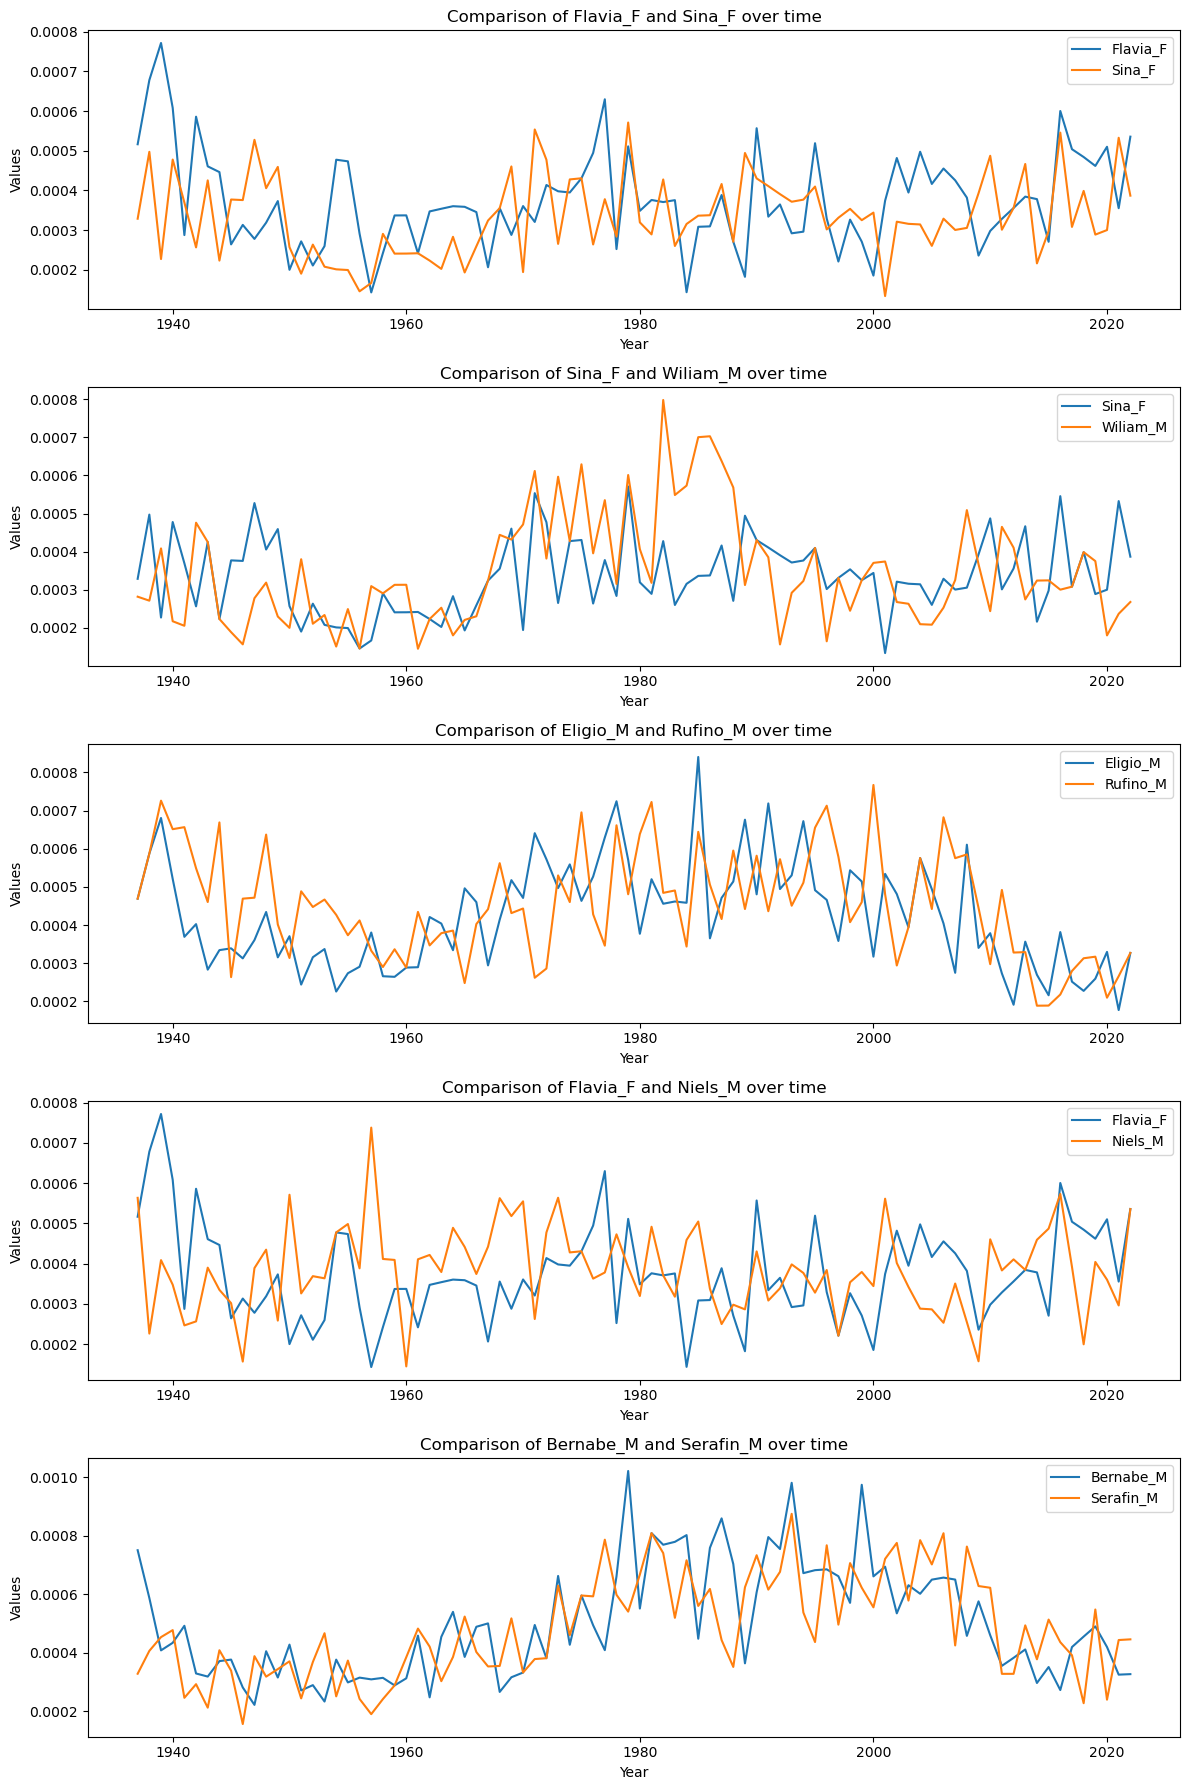

In [59]:
top_pairs = time_comparison.nsmallest(n, measure)

# Plotting the comparisons
fig, axes = plt.subplots(n, 1, figsize=(12, 18))

for idx, (row_idx, row) in enumerate(top_pairs.iterrows()):
    name1 = row['name1']
    name2 = row['name2']
    years = df_us_common.columns
    values1 = df_us_common.loc[name1, :].values
    values2 = df_us_common.loc[name2, :].values

    axes[idx].plot(years, values1, label=name1)
    axes[idx].plot(years, values2, label=name2)
    axes[idx].set_title(f'Comparison of {name1} and {name2} over time')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Values')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [62]:
n = 10
measure = 'cosine'

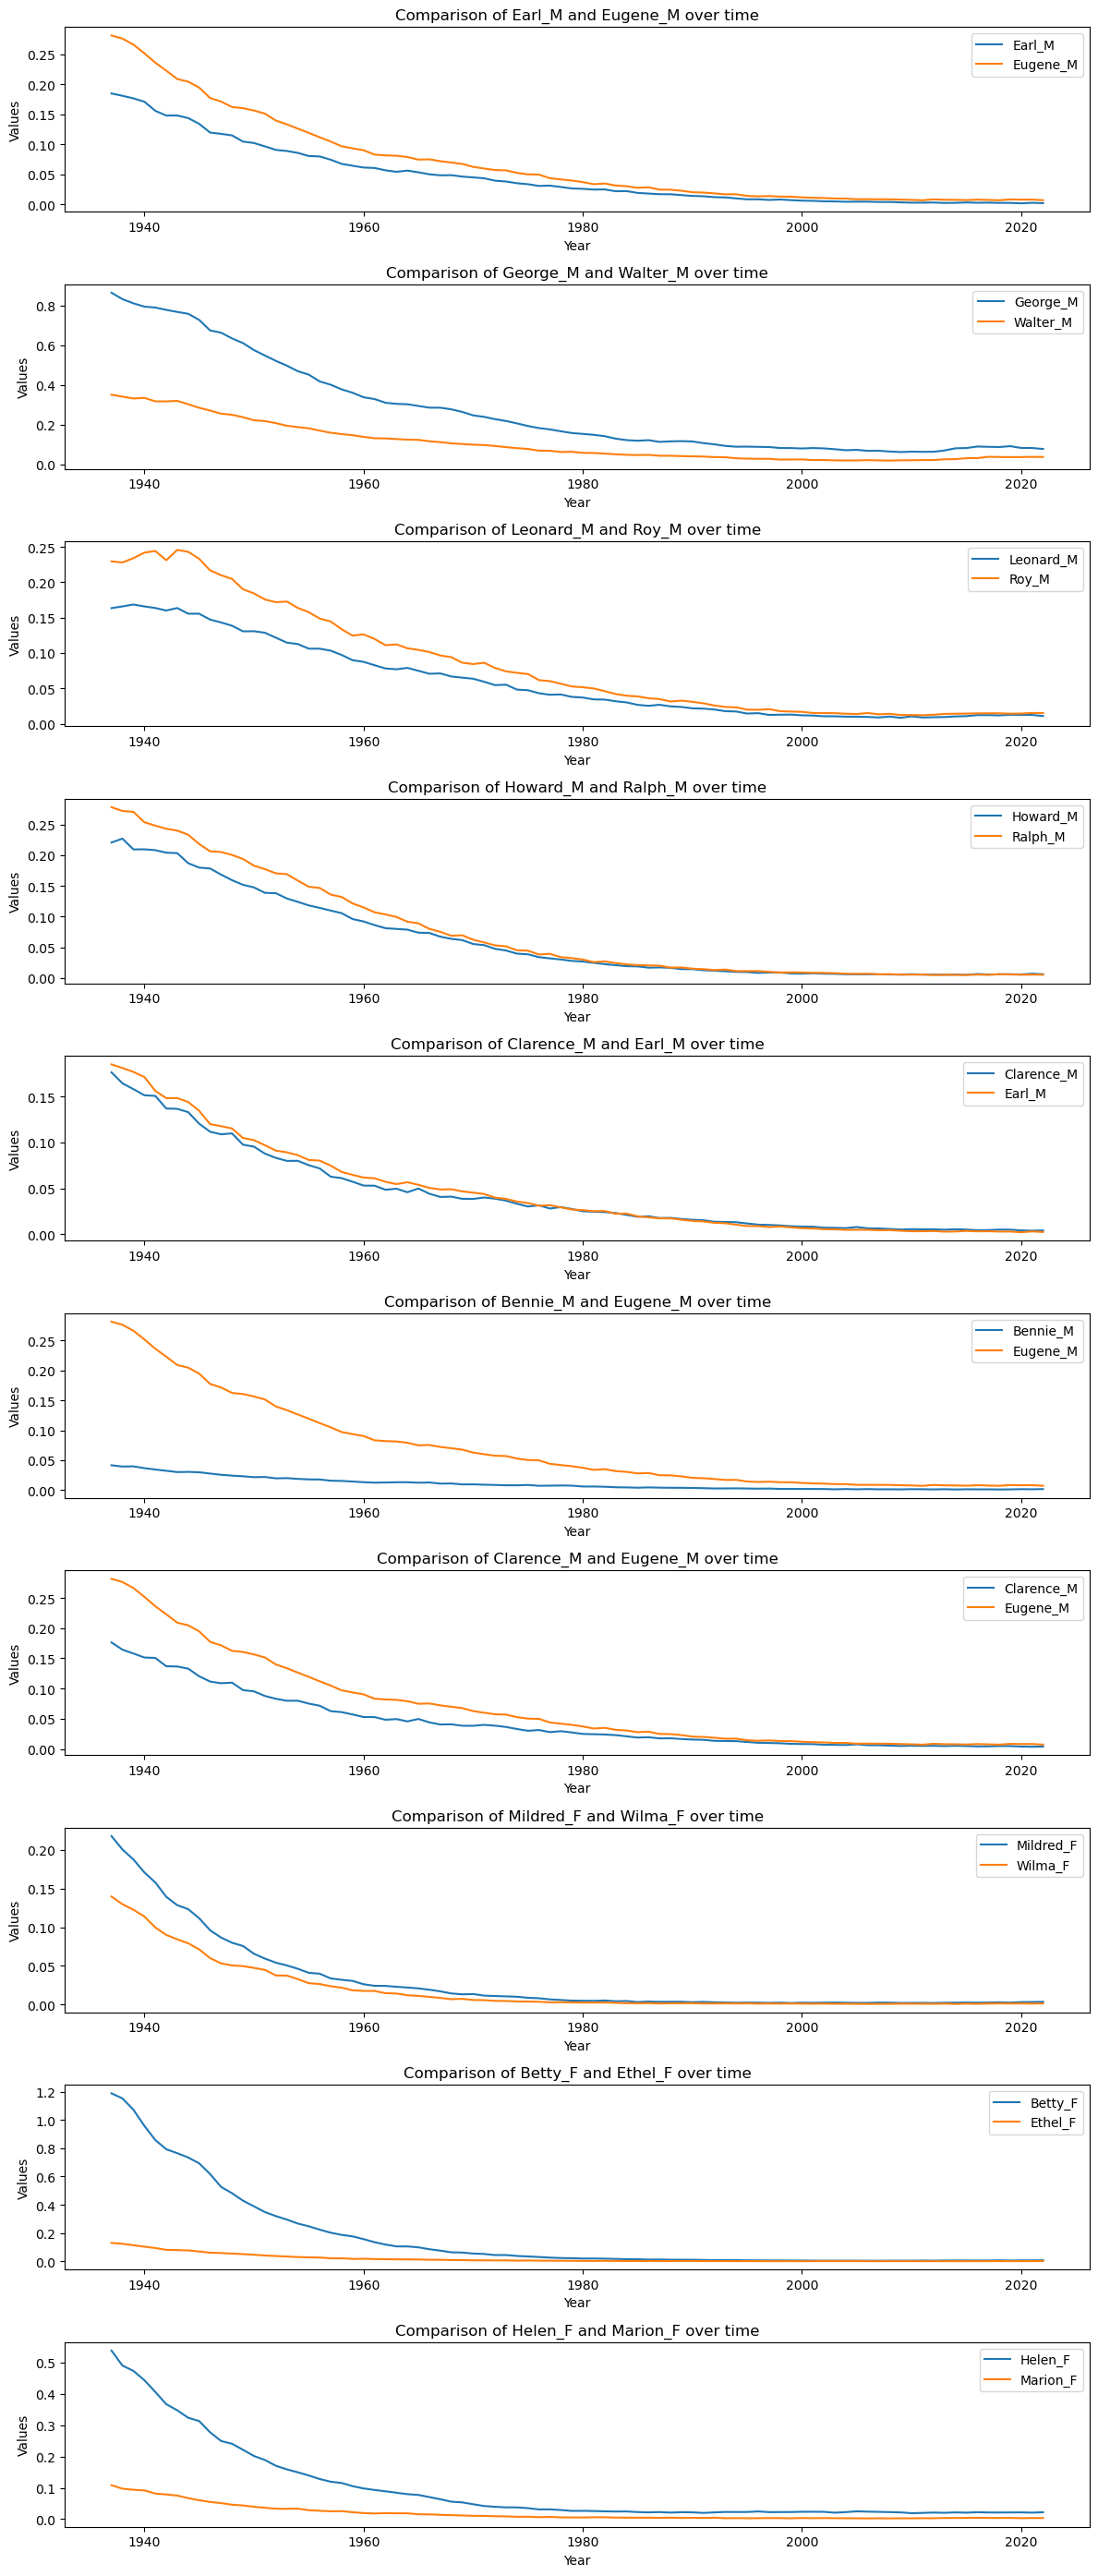

In [63]:
top_pairs = time_comparison.nsmallest(n, measure)

# Plotting the comparisons
fig, axes = plt.subplots(n, 1, figsize=(12, 28))

for idx, (row_idx, row) in enumerate(top_pairs.iterrows()):
    name1 = row['name1']
    name2 = row['name2']
    years = df_us_common.columns
    values1 = df_us_common.loc[name1, :].values
    values2 = df_us_common.loc[name2, :].values

    axes[idx].plot(years, values1, label=name1)
    axes[idx].plot(years, values2, label=name2)
    axes[idx].set_title(f'Comparison of {name1} and {name2} over time')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Values')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## The above plots all show shared steady declines. Maybe re-try with names that don't have a steady decline

## get subset of data for cross correlation and Granger causality 

In [44]:
# NOTE: n = 20 names and max_lag = 10 takes about 2-3 minutes to run the calculation loop below

n = 100 # number of names to test (if it is an odd number, it will round up to even: half M, half F)
max_lag = 10 # time lag for cross correlation. Also for Granger
current_us = df2.loc[(df2['state']=='US') & (df2['year']==max_year)]
current_us_common_names = most_common_names_by_perc(current_us, n)
current_us_common_names.head()

state  year       name M/F  count      perc
0    US  2022     Olivia   F  16573  0.492966
1    US  2022       Emma   F  14435  0.429371
2    US  2022  Charlotte   F  12891  0.383444
3    US  2022     Amelia   F  12333  0.366847
4    US  2022     Sophia   F  12310  0.366162

## Cross correlation function (CCF)
Do different time series correlate at different time lags?

## Granger causality
Is one time series useful in forecasting another?
* Do some states lead other states?
* Do some names lead other names?

Differences in trends might be due to factors other than one state influencing another (demographic shifts, cultural events like "Taylor", etc.)

In [52]:
# CAN BE SLOW, n = 20 names and max_lag = 10 takes about 2-3 minutes. results are saved to CSV so don't have to re-run


selected_results = {}
errors_list = []
for _, row in current_us_common_names.iterrows():
    name, gender = row['name'], row['M/F']
    combo_data = df2[(df2['name'] == name) & (df2['M/F'] == gender)]
    states = combo_data['state'].unique()
    combo_results_selected = {'Granger': {}, 'CCF': {}}
    for i in range(len(states)):
        state1 = states[i]
        for j in range(i + 1, len(states)):
            state2 = states[j]
            
            # Time series data for both states, fill missing years with zero percentage
            ts1 = combo_data[combo_data['state'] == state1].set_index('year')['perc'].reindex(range(combo_data['year'].min(), combo_data['year'].max() + 1), fill_value=0)
            ts2 = combo_data[combo_data['state'] == state2].set_index('year')['perc'].reindex(range(combo_data['year'].min(), combo_data['year'].max() + 1), fill_value=0)
            
            # Combine the two time series into a single DataFrame for Granger causality tests
            combined_ts = pd.concat([ts1, ts2], axis=1)
            
            # Perform Granger causality test
            # if ts1.nunique() <= 1 or ts2.nunique() <= 1:
            #     print(f"Skipping Granger causality test for {name}, {state1} and {state2} due to constant time series.")
            # else:
            try:
                granger_result = grangercausalitytests(combined_ts, maxlag=max_lag, verbose=False)
                # Using the p-value from the Granger test's Chi-squared test is a common, useful, std practice when trying to identify potential causal relationships between two time series. 
                combo_results_selected['Granger'][(state1, state2)] = {lag: result[0]['ssr_chi2test'][1] for lag, result in granger_result.items()}
            except Exception as e:
                # print(f"Error in Granger causality test between {name}, {state1} and {state2}: {e}")
                errors_list.append([name, state1, state2, e])
            
            # Calculate Cross-Correlation Function (CCF) up to max_lag
            ccf_result = ccf(ts1, ts2, adjusted=True)[:max_lag+1]  # Get CCF values for lags 0 to max_lag
            combo_results_selected['CCF'][(state1, state2)] = ccf_result
    
    
    selected_results[(name, gender)] = combo_results_selected

# display partial dictionary:
# {k: {'Granger': list(v['Granger'].items())[:1], 'CCF': list(v['CCF'].items())[:1]} for k, v in selected_results.items()}  # Limited view for clarity

Error in Granger causality test between Luna, US and DC: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, US and DE: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, US and RI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, US and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, US and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, US and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, US and NH: The x values includ

Error in Granger causality test between Luna, DC and WI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, DC and UT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, DC and LA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, DC and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, DC and CO: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, DC and MS: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, DC and NH: The 

Error in Granger causality test between Luna, DE and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, DE and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, DE and ND: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, DE and CA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, DE and VA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, DE and NJ: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, DE and AR:

Error in Granger causality test between Luna, RI and TN: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, RI and OR: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, RI and NV: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, RI and TX: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, RI and VT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, RI and MI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, RI and NE: The Granger ca

Error in Granger causality test between Luna, WA and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, WA and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, WA and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, WA and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, WA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, WA and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, WA and SD: The x values includ

Error in Granger causality test between Luna, MO and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, AL and MN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, AL and TN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, AL and OR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, AL and NV: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, AL and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, AL and NE:

Error in Granger causality test between Luna, OR and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, OR and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, OR and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, NV and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, NV and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, NV and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, NV and MS: The x values i

Error in Granger causality test between Luna, MI and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, MI and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, NE and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, NE and VA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, NE and AR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, NE and WI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, NE and UT:

Error in Granger causality test between Luna, CA and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, CA and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, CA and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, CA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, CA and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, CA and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, VA and ME: The x values includ

Error in Granger causality test between Luna, CO and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, CO and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, MS and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, MS and MD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, MS and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, MS and OH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, MS and MA: The x values includ

Error in Granger causality test between Luna, NY and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, SC and HI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, SC and KS: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, SC and IN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luna, SC and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, HI and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luna, IL and SD: The 

Error in Granger causality test between Harper, DE and SD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, PA and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, RI and IA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, RI and WV: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, RI and AZ: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, RI and OR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test be

Error in Granger causality test between Harper, AZ and OR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, AZ and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, OR and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, NV and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, NV and ND: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, NV and NJ: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test be

Error in Granger causality test between Harper, ND and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, ND and IN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, NJ and LA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, NJ and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, NJ and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Harper, NJ and IN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test be

Error in Granger causality test between Camila, ID and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Camila, ID and SC: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Camila, ID and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, ID and IN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Camila, ID and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, DC and WA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Cami

Error in Granger causality test between Camila, FL and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, FL and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, FL and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, FL and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, FL and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, PA and WV: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, PA and ND: The x

Error in Granger causality test between Camila, NC and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, NC and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, NC and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, NC and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, NC and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, NC and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, MO and ND: The x

Error in Granger causality test between Camila, OR and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, OR and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, OR and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, OR and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, OR and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, OR and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, NV and ND: The x

Error in Granger causality test between Camila, ND and MD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, ND and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, ND and OH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, ND and MA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, ND and NM: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, ND and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, ND and OK: The x

Error in Granger causality test between Camila, MS and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, MS and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, MS and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Camila, MS and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Camila, MS and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Camila, MS and SC: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Camila, M

Error in Granger causality test between Sofia, WV and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Sofia, WV and MS: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Sofia, VT and ND: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Sofia, VT and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Sofia, VT and MS: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Sofia, VT and MT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between 

Error in Granger causality test between Scarlett, RI and HI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Scarlett, IA and MN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Scarlett, IA and NV: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Scarlett, IA and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Scarlett, IA and WI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Scarlett, IA and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causa

Error in Granger causality test between Mila, ID and KY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, ID and DE: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, ID and PA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, ID and IA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, ID and WA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, ID and NC: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, ID an

Error in Granger causality test between Mila, DC and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, DC and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, DC and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, DC and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, DC and SC: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, DC and HI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, DC an

Error in Granger causality test between Mila, DE and AR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, DE and WI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, DE and UT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, DE and LA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, DE and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, DE and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, DE and MS: The 

Error in Granger causality test between Mila, IA and WI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, IA and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, IA and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, IA and MD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, IA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, IA and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, IA and GA:

Error in Granger causality test between Mila, AL and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, AL and MD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, AL and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, AL and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, AL and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, AL and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, AL an

Error in Granger causality test between Mila, NV and GA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, TX and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, TX and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, VT and MI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, VT and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, VT and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, VT and VA:

Error in Granger causality test between Mila, CA and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, CA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, VA and NJ: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, VA and WI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, VA and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, VA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, VA and MA: The Grang

Error in Granger causality test between Mila, CO and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, MS and MD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, MS and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mila, MS and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, MS and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, MS and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mila, MS an

Error in Granger causality test between Gianna, ID and KY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Gianna, ID and AL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Gianna, ID and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Gianna, ID and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Gianna, ID and AR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Gianna, ID and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test be

Error in Granger causality test between Aria, DC and RI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, DC and IA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, DC and AL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, DC and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Aria, DC and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, DC and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, DC an

Error in Granger causality test between Aria, WA and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Aria, WV and AL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, WV and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Aria, WV and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, WV and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, WV and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, WV and AR:

Error in Granger causality test between Aria, NE and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, NE and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, NE and AR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, NE and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, NE and MS: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, NE and NH: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, 

Error in Granger causality test between Aria, WY and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, WY and MT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, WY and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, WY and HI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, WY and KS: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, NM and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aria, 

Error in Granger causality test between Aurora, DC and IL: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Aurora, DC and KS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Aurora, DC and IN: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Aurora, DC and GA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Aurora, DC and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Aurora, DE and RI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Aurora, DE and WV: 

Error in Granger causality test between Nova, ID and OH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ID and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, ID and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, ID and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ID and OK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ID and NY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ID and SC: The Grang

Error in Granger causality test between Nova, KY and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, KY and NE: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, KY and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, KY and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, KY and UT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, KY and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, KY and WY: The x values includ

Error in Granger causality test between Nova, FL and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, FL and NE: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, FL and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, FL and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, FL and UT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, FL and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, FL and WY: The x values includ

Error in Granger causality test between Nova, IA and AR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, IA and WI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, IA and UT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, IA and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, IA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, IA and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, IA and NM: The 

Error in Granger causality test between Nova, AL and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, AL and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, AL and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, AL and NM: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, AL and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, AL and SC: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, AL and HI: The x values i

Error in Granger causality test between Nova, NV and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NV and NE: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NV and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NV and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NV and UT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NV and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NV and WY: The x values includ

Error in Granger causality test between Nova, NE and LA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, NE and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, NE and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, NE and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NE and NH: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, NE and MD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NE and WY:

Error in Granger causality test between Nova, ND and OK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ND and NY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ND and SC: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, ND and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ND and IL: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ND and KS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, ND and IN: The x values i

Error in Granger causality test between Nova, WI and GA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, UT and LA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, UT and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, UT and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, UT and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, UT and NH: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, UT an

Error in Granger causality test between Nova, MS and KS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, MS and IN: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, MS and GA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, MS and SD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, NH and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NH and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, NH and NM: The 

Error in Granger causality test between Nova, MT and IN: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, MT and GA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, MT and SD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Nova, OK and SC: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, OK and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NY and SC: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Nova, NY and HI: The x val

Error in Granger causality test between Isla, ID and KS: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, ID and IN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, ID and GA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, ID and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, DC and KY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, DC and DE: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, DC and FL:

Error in Granger causality test between Isla, KY and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, KY and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, KY and NY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, KY and IL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, KY and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, DE and FL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, DE and PA:

Error in Granger causality test between Isla, FL and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, FL and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, FL and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, FL and NY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, FL and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, PA and WV: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, PA and MS: The x val

Error in Granger causality test between Isla, WA and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WA and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, WA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, WA and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WA and NY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WA and IL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WA and SD:

Error in Granger causality test between Isla, MO and MN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, MO and OR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, MO and MI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, MO and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, MO and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, MO and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, MO and MA:

Error in Granger causality test between Isla, OR and NY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, OR and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, NV and MI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, NV and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, NV and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, NV and VA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, NV an

Error in Granger causality test between Isla, CT and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, CT and MA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, CT and NY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, CT and IL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, CT and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, AK and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, AK and MS:

Error in Granger causality test between Isla, WI and NY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WI and IL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WI and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, UT and CO: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, UT and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, UT and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, UT and MA: The 

Error in Granger causality test between Isla, WY and OH: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WY and MA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Isla, WY and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WY and MT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WY and OK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WY and NY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Isla, WY an

Error in Granger causality test between Willow, DC and HI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Willow, DE and RI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Willow, DE and WV: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Willow, DE and NV: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Willow, DE and VT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Willow, DE and ND: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test be

Error in Granger causality test between Eliana, DE and WV: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Eliana, DE and AL: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Eliana, DE and VT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Eliana, DE and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Eliana, DE and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Eliana, DE and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between

Error in Granger causality test between Eliana, ND and MA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Eliana, ND and NM: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Eliana, ND and MT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Eliana, ND and OK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Eliana, ND and NY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Eliana, ND and SC: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Eliana, ND and HI: 

Error in Granger causality test between Emilia, DC and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, DC and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Emilia, DC and AR: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, DC and LA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Emilia, DC and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Emilia, DC and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, D

Error in Granger causality test between Emilia, DE and IN: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, DE and GA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, DE and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, FL and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, FL and AR: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, FL and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, FL and WY: The x

Error in Granger causality test between Emilia, MO and AR: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, MO and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, MO and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, MO and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, MO and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, MO and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, AL and VT: The x

Error in Granger causality test between Emilia, VT and AR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Emilia, VT and WI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, VT and UT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, VT and LA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, VT and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, VT and CO: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, VT and MS: 

Error in Granger causality test between Emilia, CA and AR: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CA and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CA and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CA and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CA and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, VA and AR: The x

Error in Granger causality test between Emilia, ME and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, ME and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, ME and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CO and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CO and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CO and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, CO and HI: The x

Error in Granger causality test between Emilia, OK and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, NY and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, NY and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, SC and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, SC and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, HI and IL: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Emilia, HI and KS: The x

Error in Granger causality test between Elena, ME and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Elena, CO and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Elena, MS and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Elena, NH and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Elena, MD and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Elena, WY and OH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Elena, WY and MA: The x values

Error in Granger causality test between Mateo, RI and WV: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, RI and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mateo, RI and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, RI and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, RI and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, RI and MS: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Mateo, RI and NH: Th

Error in Granger causality test between Mateo, NC and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, NC and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, NC and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, NC and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, MO and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, MO and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, MO and ME: The x values

Error in Granger causality test between Mateo, AK and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, AK and CA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, AK and VA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, AK and NJ: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, AK and AR: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, AK and WI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, AK and UT: The x values

Error in Granger causality test between Mateo, CA and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, CA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, VA and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, VA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, NJ and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, NJ and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Mateo, AR and ME: The x values

Error in Granger causality test between Sebastian, WY and MT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, DC and IA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, DC and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, DC and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, DC and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, DC and ND: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test betw

Error in Granger causality test between Asher, VT and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, VT and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, VT and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, VT and ND: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, VT and AR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Asher, VT and LA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between 

Error in Granger causality test between Hudson, DC and HI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Hudson, DE and RI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Hudson, DE and WV: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Hudson, DE and NV: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Hudson, DE and CT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Hudson, DE and ND: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test be

Error in Granger causality test between Luca, ID and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, DC and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, DC and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, DC and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, DC and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, DC and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, DC and OK: The x values includ

Error in Granger causality test between Luca, RI and AZ: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luca, RI and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, RI and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, RI and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, RI and VA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luca, RI and WI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luca, RI and UT: The 

Error in Granger causality test between Luca, NC and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NC and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NC and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NC and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NC and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NC and OK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NC and SD: The x values includ

Error in Granger causality test between Luca, TN and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, TN and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luca, TN and OK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, TN and IN: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luca, TN and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, OR and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, OR and AK: The x val

Error in Granger causality test between Luca, MI and OK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, MI and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NE and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NE and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NE and VA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luca, NE and WI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Luca, NE and UT: The Grang

Error in Granger causality test between Luca, CA and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, VA and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, VA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, VA and OK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, VA and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NJ and MS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, NJ and WY: The x values includ

Error in Granger causality test between Luca, MD and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, WY and OH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, WY and MA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, WY and NM: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, WY and MT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, WY and OK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Luca, WY and NY: The x values includ

Error in Granger causality test between Grayson, VT and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Grayson, VT and AK: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Grayson, VT and ND: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Grayson, VT and ME: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Grayson, VT and NH: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Grayson, VT and NM: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality t

Error in Granger causality test between Maverick, KY and OR: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, KY and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, KY and NE: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, KY and CT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, KY and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, KY and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ma

Error in Granger causality test between Maverick, DE and SD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, FL and RI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, FL and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, FL and CT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, FL and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, FL and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maveric

Error in Granger causality test between Maverick, IA and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, IA and CT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, IA and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, IA and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, IA and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, IA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, WA

Error in Granger causality test between Maverick, MN and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, MN and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, MN and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, TN and VT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, TN and CT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, TN and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, TN

Error in Granger causality test between Maverick, NE and CT: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, NE and AK: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, NE and ND: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, NE and VA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, NE and UT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, NE and ME: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ma

Error in Granger causality test between Maverick, AK and SD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, ND and CA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, ND and VA: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, ND and NJ: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, ND and AR: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, ND and WI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ma

Error in Granger causality test between Maverick, MS and SC: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, MS and SD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, NH and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, MD and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Maverick, MD and SD: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Maverick, WY and OH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test betwe

Error in Granger causality test between Santiago, FL and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, FL and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, FL and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, FL and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, PA and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, PA and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, PA

Error in Granger causality test between Santiago, NV and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, NV and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, TX and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, TX and WY: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, TX and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, TX and SD: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, MI

Error in Granger causality test between Santiago, NH and SC: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, NH and HI: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, NH and IL: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, NH and KS: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, NH and IN: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, NH and GA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Santiago, NH

Error in Granger causality test between Ezekiel, KY and DE: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel, KY and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel, DE and FL: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel, DE and PA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel, DE and RI: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Ezekiel, DE and IA: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel, DE a

Error in Granger causality test between Ezekiel, RI and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel, RI and WY: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Ezekiel, IA and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel, WA and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel, WV and VT: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.
Error in Granger causality test between Ezekiel, WV and NH: The x values include a column with constant values and so the test statistic cannot be computed.
Error in Granger causality test between Ezekiel,

In [ ]:
# make dataframes of the results
granger_results = []  
ccf_results = []      

for (name, gender), results in selected_results.items():
    for (state1, state2), granger_values in results['Granger'].items():
        for lag, p_value in granger_values.items():
            granger_results.append({'Name': name, 'Gender': gender, 'State1': state1, 'State2': state2, 'Lag': lag, 'P_value': p_value})
    
    for (state1, state2), ccf_values in results['CCF'].items():
        for lag, value in enumerate(ccf_values):
            ccf_results.append({'Name': name, 'Gender': gender, 'State1': state1, 'State2': state2, 'Lag': lag, 'CCF_value': value})

errors_df = pd.DataFrame(errors_list, columns=['name', 'state1', 'state2', 'error'])
granger_df = pd.DataFrame(granger_results)
ccf_df = pd.DataFrame(ccf_results)

In [53]:
# save results to CSV in case I want to explore the results without re-running Granger and CCF
name_suffix = '_' + str(n) + 'x' + str(max_lag)
granger_df.to_csv('compare_granger' + name_suffix + '.csv')
ccf_df.to_csv('compare_ccf' + name_suffix + '.csv')
errors_df.to_csv('compare_errors' + name_suffix + '.csv')

In [54]:
errors_df.head()

name state1 state2                                              error
0  Luna     US     DC  The x values include a column with constant va...
1  Luna     US     DE  The x values include a column with constant va...
2  Luna     US     RI  The x values include a column with constant va...
3  Luna     US     VT  The x values include a column with constant va...
4  Luna     US     ME  The x values include a column with constant va...

In [55]:
granger_df.head(10)

Name Gender State1 State2  Lag   P_value
0  Olivia      F     US     ID    1  0.405683
1  Olivia      F     US     ID    2  0.010608
2  Olivia      F     US     ID    3  0.010157
3  Olivia      F     US     ID    4  0.020256
4  Olivia      F     US     ID    5  0.034470
5  Olivia      F     US     ID    6  0.014638
6  Olivia      F     US     ID    7  0.031428
7  Olivia      F     US     ID    8  0.048335
8  Olivia      F     US     ID    9  0.085711
9  Olivia      F     US     ID   10  0.048176

In [56]:
ccf_df.head(10)

Name Gender State1 State2  Lag  CCF_value
0  Olivia      F     US     ID    0   0.985615
1  Olivia      F     US     ID    1   0.975132
2  Olivia      F     US     ID    2   0.956601
3  Olivia      F     US     ID    3   0.938220
4  Olivia      F     US     ID    4   0.916356
5  Olivia      F     US     ID    5   0.890940
6  Olivia      F     US     ID    6   0.867776
7  Olivia      F     US     ID    7   0.839103
8  Olivia      F     US     ID    8   0.800039
9  Olivia      F     US     ID    9   0.769543

## CCF results

In [57]:
# ignore US vs state combinations?

#### CCF: highest values for different lags (incl Lag 0). plot some name pairs together

In [64]:
max_ccfs = ccf_df.loc[ccf_df.groupby('Lag')['CCF_value'].idxmax()]
max_ccfs

Name Gender State1 State2  Lag  CCF_value
160644    Camila      F     US     TX    0   0.999521
1143374    Aiden      M     TN     OH    1   1.007013
170513    Camila      F     ND     MT    2   1.023810
1394583   Jayden      M     CA     OH    3   1.032036
1392505   Jayden      M     TX     HI    4   1.033941
485006   Madison      F     WV     UT    5   1.041803
491717   Madison      F     WI     UT    6   1.037767
1136780    Aiden      M     DC     VT    7   1.034077
1197545    Logan      M     RI     WV    8   1.032140
246321     Emily      F     NM     KS    9   1.032737
1190826    Jacob      M     NJ     LA   10   1.044186

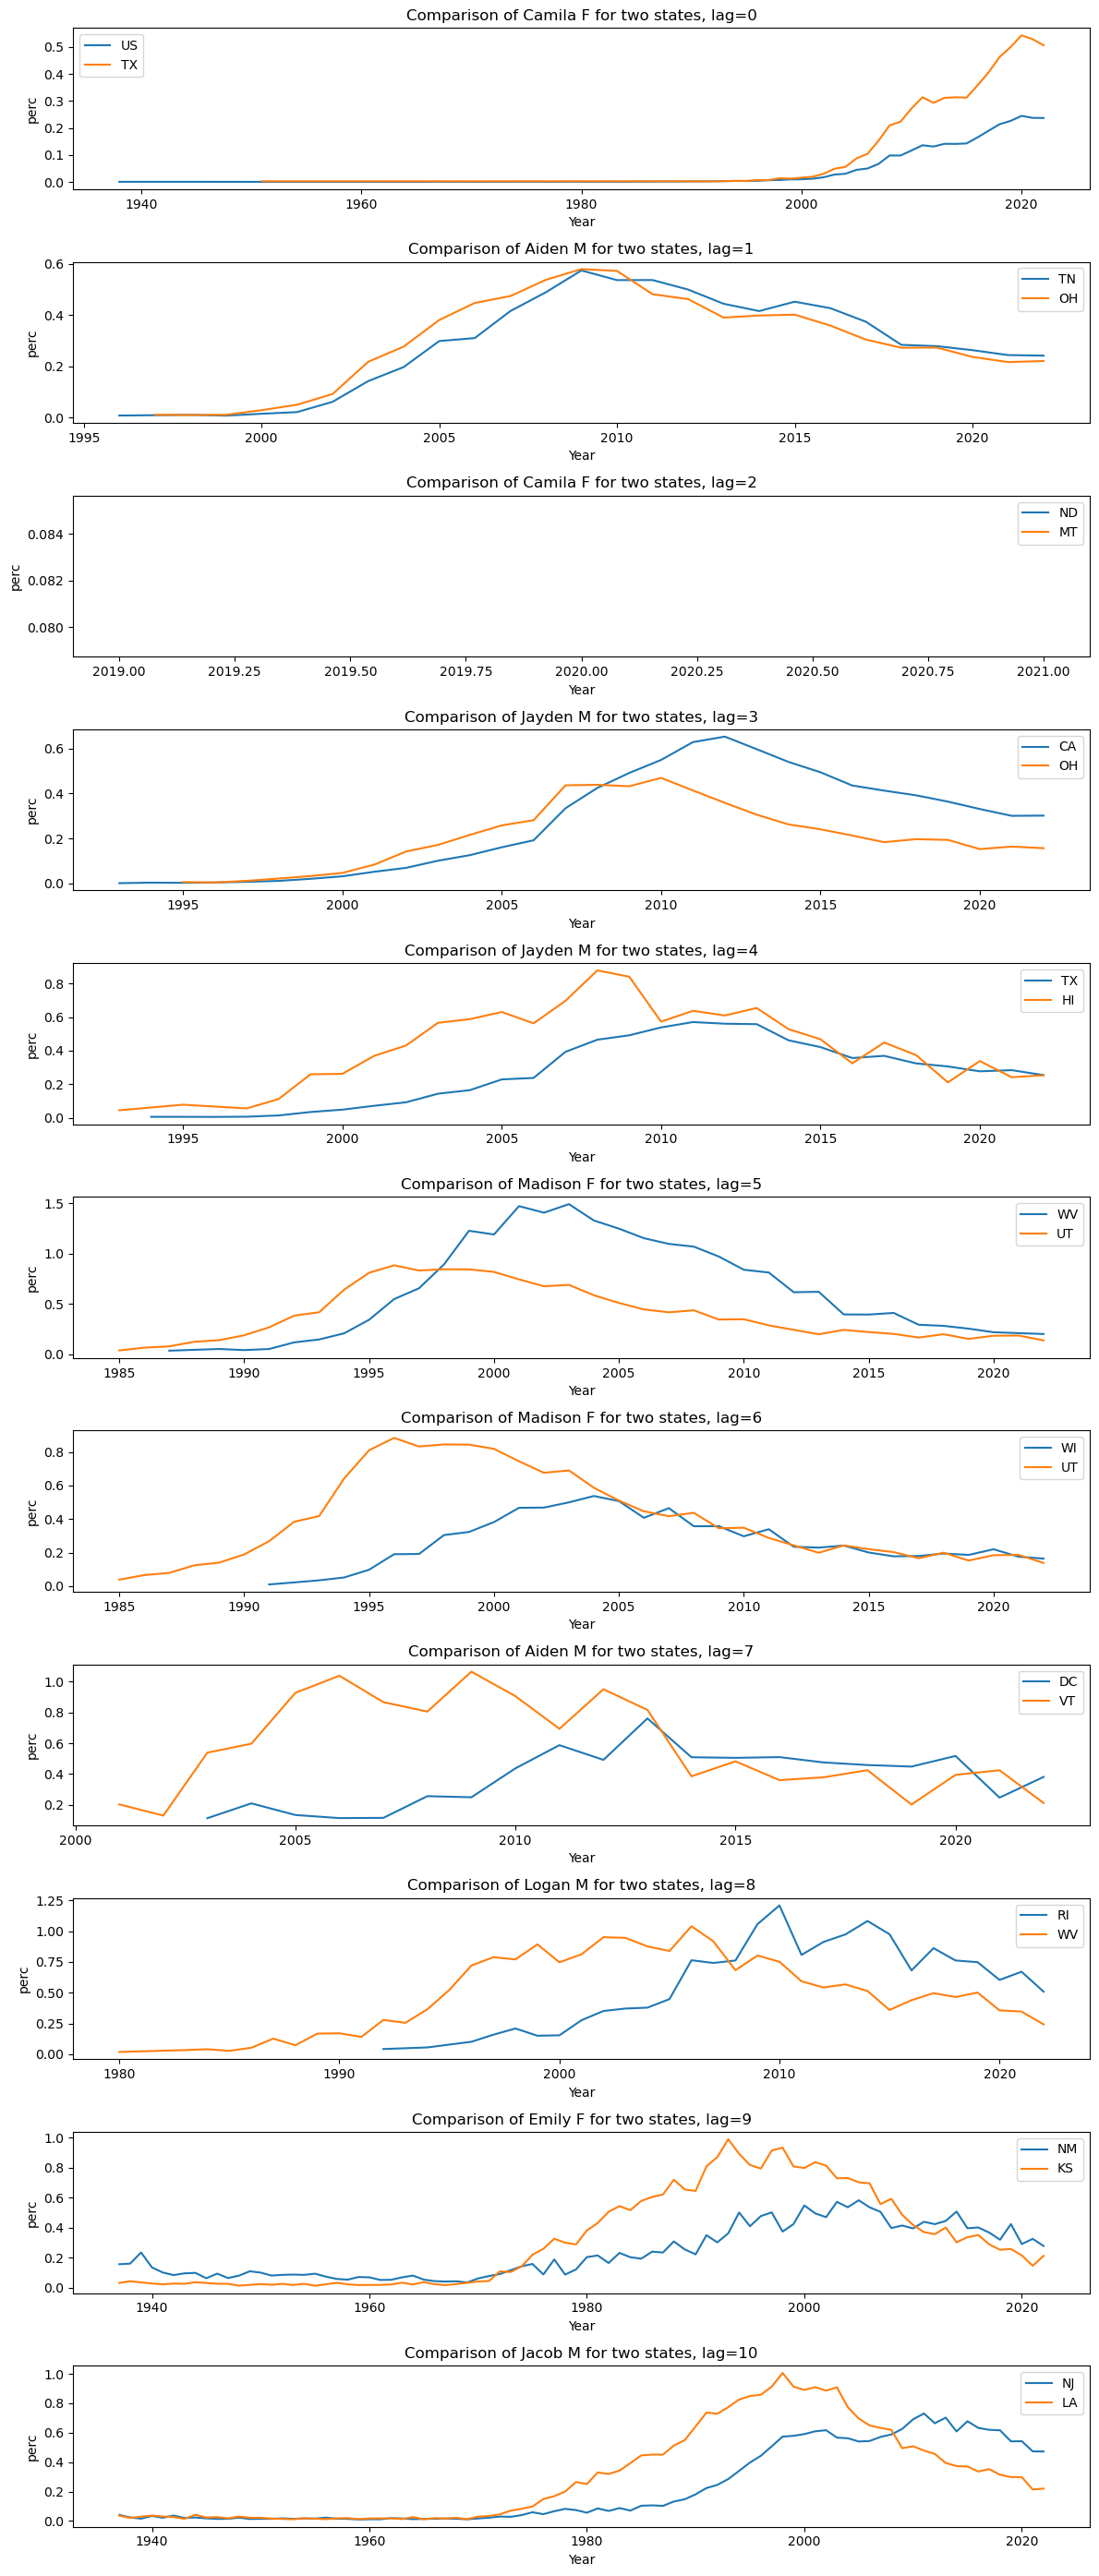

In [76]:
fig, axes = plt.subplots(max_lag+1, 1, figsize=(12, 28))

for idx, (row_idx, row) in enumerate(max_ccfs.iterrows()):
    name = row['Name']
    gender = row['Gender']
    state1 = row['State1']
    state2 = row['State2']
    
    lag = row['Lag']
    ccf = row['CCF_value']
    
    temp1 = df2.loc[(df2['name']==name) & (df2['M/F']==gender) & (df2['state']==state1)].sort_values(['year'])
    temp2 = df2.loc[(df2['name']==name) & (df2['M/F']==gender) & (df2['state']==state2)].sort_values(['year'])


    axes[idx].plot(temp1['year'], temp1['perc'], label=state1) # , marker='o'
    axes[idx].plot(temp2['year'], temp2['perc'], label=state2)
    axes[idx].set_title(f'Comparison of {name} {gender} for two states, {state1} and {state2}, lag={lag}')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('perc')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [77]:
# what's up with the blank plot above?
df2.loc[(df2['name']=='Camila') & (df2['M/F']=='F') & (df2['state']=='ND')].sort_values(['year'])
# Oh, there is only one data point

state  year    name M/F  count      perc
4222036    ND  2021  Camila   F      5  0.079039

In [78]:
df2.loc[(df2['name']=='Camila') & (df2['M/F']=='F') & (df2['state']=='MT')].sort_values(['year'])

state  year    name M/F  count      perc
6074713    MT  2019  Camila   F      5  0.085339

#### CCF: highest AVERAGE for different lags (incl Lag 0). Must populate some with zeros before calculating averages?

In [85]:
average_ccf_for_state_pairs = ccf_df.groupby(['State1', 'State2', 'Lag']).mean(numeric_only=True).reset_index()
average_ccf_for_state_pairs

State1 State2  Lag  CCF_value
0         AK     AR    0   0.856019
1         AK     AR    1   0.815424
2         AK     AR    2   0.767739
3         AK     AR    3   0.717510
4         AK     AR    4   0.664209
...      ...    ...  ...        ...
14581     WY     SD    6   0.610076
14582     WY     SD    7   0.565593
14583     WY     SD    8   0.515481
14584     WY     SD    9   0.465249
14585     WY     SD   10   0.428207

[14586 rows x 4 columns]

In [87]:
max_ave_ccfs = average_ccf_for_state_pairs.loc[average_ccf_for_state_pairs.groupby('Lag')['CCF_value'].idxmax()]
max_ave_ccfs

State1 State2  Lag  CCF_value
6336      MI     OH    0   0.988387
6337      MI     OH    1   0.953046
11970     US     CO    2   0.915456
11971     US     CO    3   0.876606
12170     US     MN    4   0.833548
12171     US     MN    5   0.792604
12172     US     MN    6   0.748476
10336     PA     MN    7   0.702391
10337     PA     MN    8   0.655441
3397      FL     MN    9   0.606165
3398      FL     MN   10   0.564135

## Granger results

#### Granger: look at some low p-values (ignore p-values>.05). plot some pairs together

In [90]:
min_granger = granger_df.loc[granger_df.groupby('Lag')['P_value'].idxmin()]
min_granger

Name Gender State1 State2  Lag        P_value
89450        Ava      F     ND     MA    1  7.974030e-105
389191      Nova      F     NC     WI    2  1.684174e-138
389012      Nova      F     WV     KS    3  1.953525e-271
231513      Mila      F     OK     KS    4   0.000000e+00
224584      Mila      F     FL     AK    5   0.000000e+00
119605      Luna      F     US     UT    6   0.000000e+00
119606      Luna      F     US     UT    7   0.000000e+00
81647        Ava      F     DE     MN    8   0.000000e+00
80308        Ava      F     ID     ND    9   0.000000e+00
68069   Isabella      F     KY     WI   10   0.000000e+00

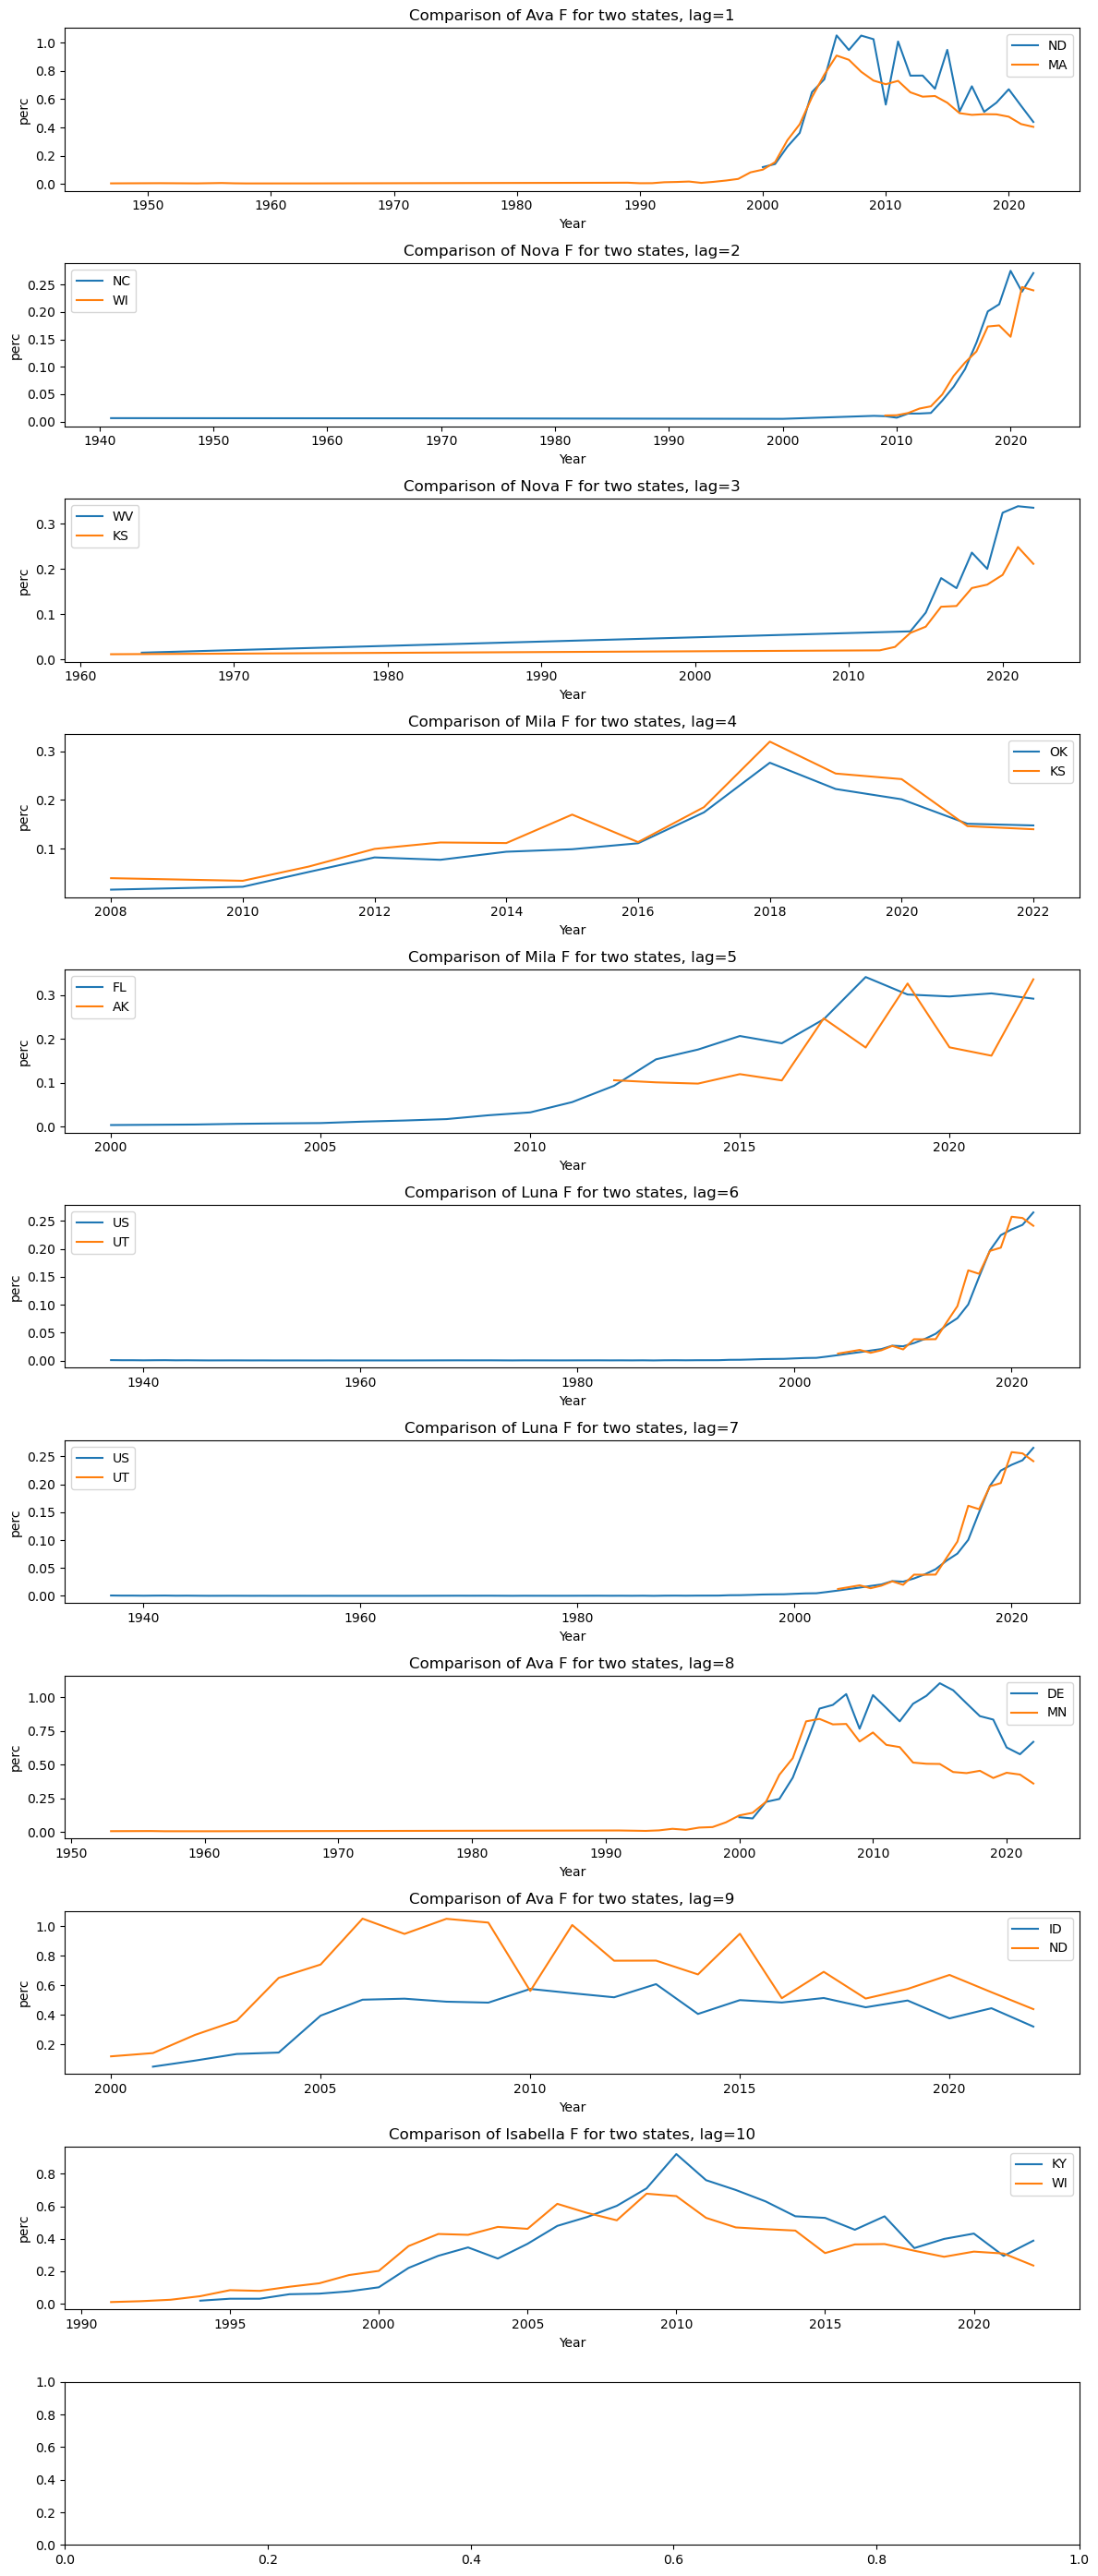

In [91]:
fig, axes = plt.subplots(max_lag+1, 1, figsize=(12, 28))

for idx, (row_idx, row) in enumerate(min_granger.iterrows()):
    name = row['Name']
    gender = row['Gender']
    state1 = row['State1']
    state2 = row['State2']
    
    lag = row['Lag']
    pval = row['P_value']
    
    temp1 = df2.loc[(df2['name']==name) & (df2['M/F']==gender) & (df2['state']==state1)].sort_values(['year'])
    temp2 = df2.loc[(df2['name']==name) & (df2['M/F']==gender) & (df2['state']==state2)].sort_values(['year'])

    axes[idx].plot(temp1['year'], temp1['perc'], label=state1) # , marker='o'
    axes[idx].plot(temp2['year'], temp2['perc'], label=state2)
    axes[idx].set_title(f'Comparison of {name} {gender} for two states, {state1} and {state2}, lag={lag}')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('perc')
    axes[idx].legend()

plt.tight_layout()
plt.show()

#### Granger: do some of the state/lag combinations have lots of low p-values?

In [93]:
significant_counts = granger_df[granger_df['P_value'] < 0.05].groupby(['State1', 'State2', 'Lag']).size().reset_index(name='Count')
significant_counts.head()

State1 State2  Lag  Count
0     AK     AR    1     74
1     AK     AR    2     65
2     AK     AR    3     70
3     AK     AR    4     71
4     AK     AR    5     74

In [94]:
max_counts = significant_counts.loc[significant_counts.groupby('Lag')['Count'].idxmax()]
max_counts

State1 State2  Lag  Count
4570     KY     IN    1     95
531      AL     OH    2     98
8092     NJ     NY    3     97
4763     KY     OH    4     97
4764     KY     OH    5     97
5065     LA     OH    6     99
5066     LA     OH    7     99
5067     LA     OH    8     99
4568     KY     IL    9     98
3209     FL     OH   10    100

In [ ]:
# visulaize and/or network analysis: 
#     states are nodes, directed edges represent leading relationship. Can I do US map with arrows?

# test any conclusions with other sets of names